Загрузка библиотек

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

Импорт файла с данными для сравнения:

In [4]:
exp = pd.read_csv('EngineSem.ind', encoding='latin-1', header=None, skiprows = 19, delimiter='\s+')
exp.columns = ['Fi', 'Pc', 'Tc', 'Vc', 'Alf_w', 'P_1ring', 'G_bb', 'P_pist', 'x']
exp = exp[['Fi', 'Pc', 'Tc', 'x']]
exp['Pc'] = exp['Pc']*10**5
exp

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\User\AppData\Local\Temp\ipykernel_11140\2957874274.py:1: SyntaxWarning: invalid escape sequence '\s'
  exp = pd.read_csv('EngineSem.ind', encoding='latin-1', header=None, skiprows = 19, delimiter='\s+')


,Fi,Pc,Tc,x
0,180.0,193000.0,346.4,2.000000e+25
1,181.0,193000.0,346.5,2.000000e+25
2,182.0,193000.0,346.6,2.000000e+25
3,183.0,193000.0,346.7,2.000000e+25
4,184.0,193000.0,346.8,2.000000e+25
...,...,...,...,...
716,896.0,193000.0,346.2,2.000000e+25
717,897.0,192000.0,346.2,2.000000e+25
718,898.0,192000.0,346.3,2.000000e+25
719,899.0,192000.0,346.4,2.000000e+25


# Исходные данные по двигателю

### Геометрические параметры двигателя

In [5]:
D=0.102          # диаметр цилиндра, м
S=0.122          # ход поршня, м
n_mex=0.82956    # механический КПД
n=2400           # частота вращения, об/мин
icyl=6           # кол-во цилиндров
eps=18           # степень сжатия
lamb=0.264       # R/L
qc  = 7.05e-05  # Цикловая подача
Hu = 42.5*10**6

### Прочие константы

In [6]:
Rm=8.314          # Универсальная газовая постоянная
dFi=2400 / 60 / 360     # Приращение угла поворота КВ
N=900             # Статическое количество элементов в массивах

# Функции

### Объем КС как функция угла поворота коленчатого вала:
$$ V(\phi) = V_c + V_h -\frac{\pi D^2} 4 \frac{S} 2 ((1 - cos (\phi))-\frac{\lambda} 4 (1 -cos(2\phi)))$$

In [7]:
def Vol(deg):
    Ap = np.pi * D ** 2 / 4
    Vh = Ap * S
    Vc = Vh / (eps - 1)
    V = Vc + Vh - Ap * S / 2 * (1 - np.cos(np.deg2rad(deg)) - lamb / 4 * (1 - np.cos(2*np.deg2rad(deg))))
    return (V)

### Термодинамическая работа
$$ \frac{dL} {d\phi} = -p\frac{dV}{d\phi} $$

In [8]:
def dL(P, Fi):
    dl = -P * (Vol(Fi+1) - Vol(Fi))/dFi
    return dl

### Теплообмен с окружающими деталями КС:
$$ \frac{dQ_w} {d\phi} = \qquad \sum_{i=1}^3 \alpha_w(T-T_w^i)F_i \frac{dt}{d\omega} $$
Площадь крышки цилиндра:
$$ F_k = \frac{\pi D^2} 4 $$
Площадь поршня:
$$ F_p = 1.4 F_k $$
Площадь гильзы:
$$ F_{cyl}(\phi) = {\pi D}(\delta + S_p(\phi)) $$
Коэффициент теплоотдачи по формуле Г. Эйхельберга:
$$ \alpha_w(\phi) = 77.9 \cdot 10^{-4} C_m^{\frac 1 3} \sqrt{PT} $$

In [9]:
def dQw(P, T, Fi):
    delta = 0.005
    T_h = 473
    T_cyl = 420
    T_p = 521
    Cm = S * n / 30
    Fpist = np.pi*D**2/4
    Vh = Fpist * S
    Vc = Vh / (eps - 1)
    Fcyl = ((Vol(Fi) - Vc) / Fpist + delta) * np.pi * D
    alfa_w =77.9 * 10 ** (-4) * Cm ** (1 / 3) * np.sqrt(P * T)
    dQh = alfa_w * (T - T_h) * 1.4 * Fpist
    dQcyl = alfa_w * (T - T_cyl) * Fcyl
    dQp = alfa_w * (T - T_p) * Fpist
    dqw = -(dQp + dQcyl + dQh) / (np.pi * n / 30)
    return dqw

# Основная программа

### Получение данных о характеристике тепловыделения

Пусть пока теплоемкость будет 25

In [10]:
cv = 25

Определим слагаемые для Первого Закона Термодинамики


$$ \dfrac{dQ_{сг}} {d\phi} = \dfrac{dU} {d\phi} - \dfrac{dL} {d\phi} - \dfrac{dQ_w} {d\phi} $$
$$ \dfrac{dU} {d\phi} = C_v\dfrac{d(MT)} {d\phi}  \quad | pV = MRT | \quad = \frac{C_v}{R_m}\dfrac{d(pV)} {d\phi}$$ 
$$ \frac{dL} {d\phi} = -p\frac{dV}{d\phi} $$
$$ \frac{dQ_w} {d\phi} = \qquad \sum_{i=1}^3 \alpha_w(T-T_w^i)F_i \frac{dt}{d\omega} $$
Тогда формула для тепла выделившегося при сгорании примет вид:
$$ \dfrac{dQ_{сг}} {d\phi} = (\frac{C_v}{R_m}+1)p\frac{dV}{d\phi} + \frac{C_v}{R_m}V\frac{dp}{d\phi} -\dfrac{dQ_w} {d\phi}  $$

In [11]:
## написать цикл для определения  dQc по углу поворота КВ
def dQc(Fi):
    dU = (cv/Rm + 1) * exp['Pc'][Fi] * (Vol(Fi + 1) - Vol(Fi)) / dFi
    dL = -cv/Rm * Vol(Fi) * (exp['Pc'][Fi + 1] - exp['Pc'][Fi]) /dFi
    return (dU - dL - dQw(exp['Pc'][Fi], exp['Tc'][Fi], Fi)) / 10

График тепла   $ \dfrac{dQ_{сг}} {d\phi} $ от угла поворота КВ

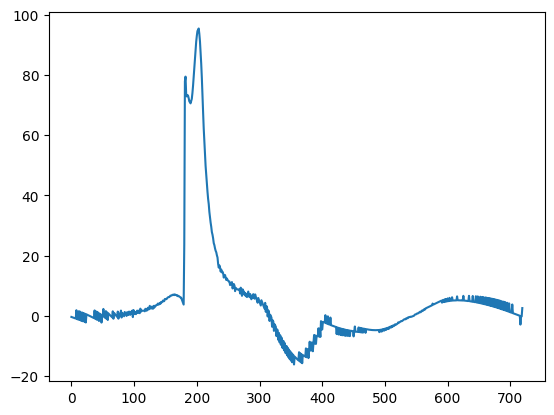

In [12]:
## отобразить на графике dQcdFi по углу поворота КВ
plt.plot([dQc(Fi) for Fi in range(720)])

Скорость тепловыделения:
$$ \dfrac{dQ_{сг}} {d\phi} = Hu\dfrac{dx} {d\phi}q_c $$

График тепла   $ \dfrac{dx} {d\phi} $ от угла поворота КВ

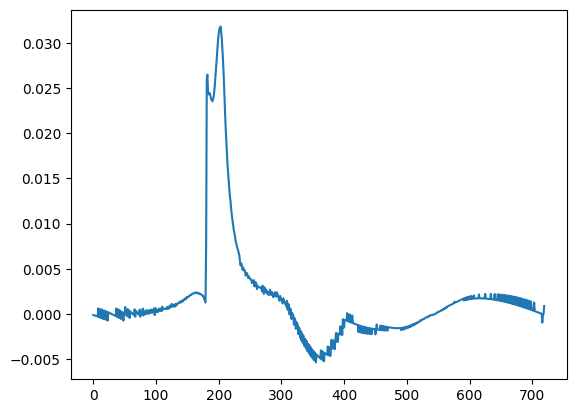

In [13]:
## отобразить на графике dXdFi (как dQcdFi/Hu/qc ) по углу поворота КВ
plt.plot([dQc(Fi)/Hu/qc for Fi in range(720)])

Необходимо на интервале где происходит сгорание - записать dXdFi в отдельную переменную

In [14]:
## отдельно записать в переменную участок dXdFi по углу поворота КВ от начала сгорания
dx_exp = [dQc(Fi)/Hu/qc for Fi in range(720)][179:259]

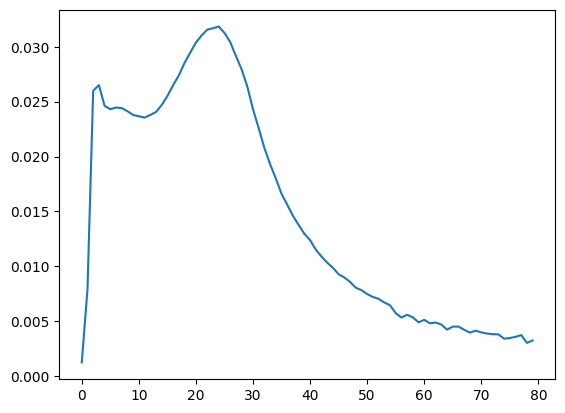

In [15]:
## отобразить на графике dXdFi  по углу поворота КВ
plt.plot(dx_exp)

In [16]:
sum(dx_exp)

np.float64(1.18540165339572)

### Использование формулы Вибе для моделирования сгорания

Для дизельного двигателя можно записать с следующим виде:
$$ \dfrac{dx_{диз}} {d\phi} =  \dfrac{dx_{об}} {d\phi} + \dfrac{dx_{диф}} {d\phi} $$
Для объемного сгорания:
$$ \dfrac{dx_{об}} {d\phi} =\chi_t [\frac{m_t}{\phi_{сг}}][\frac{\phi}{\phi_{сг}}]exp(-\frac{m_t}{m_t+1}[\frac{\phi}{\phi_{сг}}]^{m_t+1})$$
Для диффузионного сгорания:
$$ \dfrac{dx_{диф}} {d\phi} = (1-\chi_t) C [\frac{m_v+1}{\phi_{z}}][\frac{\phi}{\phi_{z}}]exp(-C[\frac{\phi}{\phi_{z}}]^{m_v+1})$$
$ \chi_t $ - доля топлива сгоревшего по кинетическому механизму;

$ m_t $ - показатель кинетического сгорания;

$ \phi_{сг} $ - угол максимального скорости кинетического сгорания;

$ m_v $ - показатель объемного сгорания;

$ С = -ln[1-\Delta x] $ 

$\Delta x $ - доля сгоревшего топлива за весь процесс (обычно принимается ~0.99);

$ \phi_{z} $ - полная продолжительность процесса сгорания.

Необходимо подобрать константы (кроме тех, что можно "взять с графика")

In [17]:
## записать выражения для констант в Формуле Вибе
ksi = 0.1
dx = 0.99
mt = 1
mv = 1
Fiz = 80
n_count = Fiz
Fic = 4
C = -np.log(1-dx)

Записать функцию для определения скорости тепловыделения

In [18]:
## def функция по углу поворота - и ее скинуть в основной файл - попозже !
def funcdxdf(Fi, ksi, mt, mv, Fiz, Fic):
    dxob = ksi * (mt / Fic) * (Fi / Fic) * np.exp(-mt / (mt + 1) * (Fi/Fic) ** (mt + 1))
    dxdif = (1 - ksi) * C * (mv + 1) / Fiz * (Fi / Fiz) * np.exp(-C * (Fi / Fiz) ** (mv + 1))
    return dxob + dxdif

In [19]:
Fi = np.linspace(0, Fiz, n_count)
## создать переменную и используя функция записать значения скорости тепловыделения по углу поворота КВ
dxdfi = funcdxdf(Fi, ksi, mt, mv, Fiz, Fic)

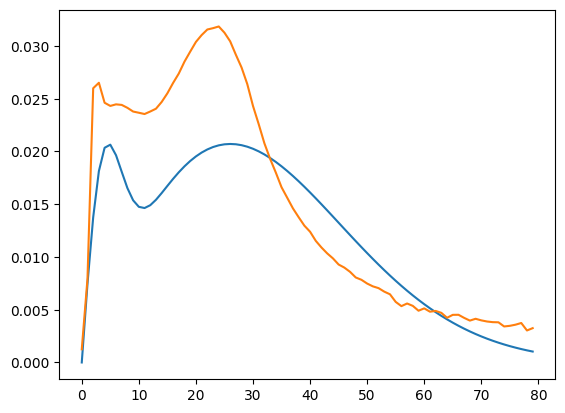

In [20]:
## Отобразить и сравнить получившиемся значения скорости тепловыделения
plt.plot(dxdfi)
plt.plot(dx_exp)

In [35]:
def error(x):
    ksi1, mt1, mv1, Fic1 = x
    Fi = np.linspace(0, Fiz, n_count)
    return sum((dx_exp - funcdxdf(Fi, ksi1, mt1, mv1, Fiz, Fic1)) ** 8)

In [36]:
dx_exp

[np.float64(0.0012483153373186275),
 np.float64(0.007908336086010307),
 np.float64(0.02598846702478507),
 np.float64(0.02650797366634626),
 np.float64(0.024614007243347915),
 np.float64(0.024313305804068232),
 np.float64(0.024462986372050785),
 np.float64(0.024409885872547298),
 np.float64(0.02413189733757158),
 np.float64(0.023781031832508206),
 np.float64(0.023666369800301346),
 np.float64(0.023545517277447477),
 np.float64(0.02378516671946304),
 np.float64(0.024048996203143713),
 np.float64(0.024690186765672535),
 np.float64(0.025509739043163306),
 np.float64(0.02649043057822897),
 np.float64(0.027384337169848973),
 np.float64(0.028514055350957218),
 np.float64(0.029459468845163622),
 np.float64(0.030378916947794394),
 np.float64(0.03102805011906574),
 np.float64(0.03155636744386513),
 np.float64(0.03168263481932553),
 np.float64(0.03184270045771035),
 np.float64(0.031253860500551886),
 np.float64(0.03043634005205512),
 np.float64(0.029160598434517834),
 np.float64(0.027949831367228

In [37]:
rez = minimize(error, [ksi, mt, mv, Fic], method='BFGS', tol=1e-20)
rez

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 3.068473460093689e-16
        x: [ 1.388e-01  1.017e+00  1.214e+00  3.991e+00]
      nit: 77
      jac: [-1.802e-17  1.584e-16 -1.059e-17 -2.734e-17]
 hess_inv: [[ 6.548e+12  1.230e+12  8.632e+12 -5.353e+11]
            [ 1.230e+12  2.571e+11  2.049e+12 -1.150e+11]
            [ 8.632e+12  2.049e+12  1.839e+13 -9.429e+11]
            [-5.353e+11 -1.150e+11 -9.429e+11  5.179e+10]]
     nfev: 709
     njev: 140

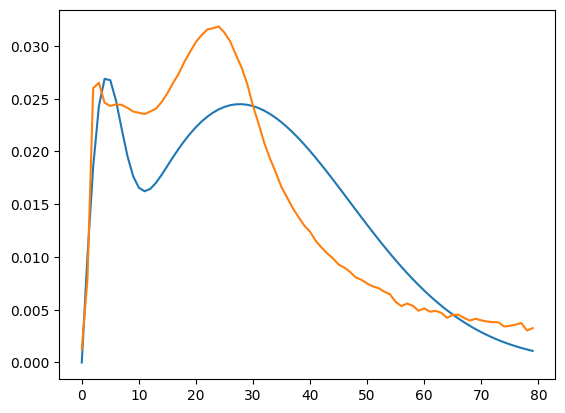

In [38]:
ksi2, mt2, mv2, Fic2 = rez.x
Fi = np.linspace(0, Fiz, n_count)
plt.plot(funcdxdf(Fi, ksi2, mt2, mv2, Fiz, Fic2))
plt.plot(dx_exp)

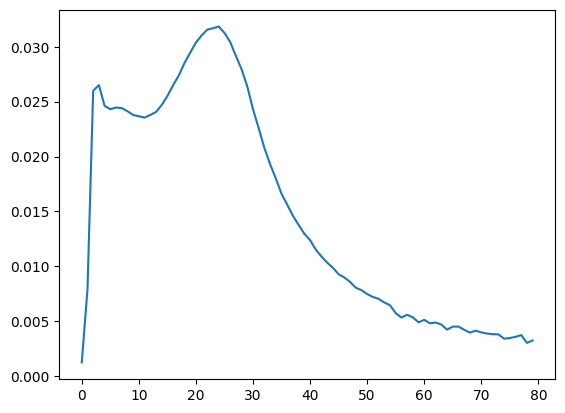

In [39]:
plt.plot(dx_exp)

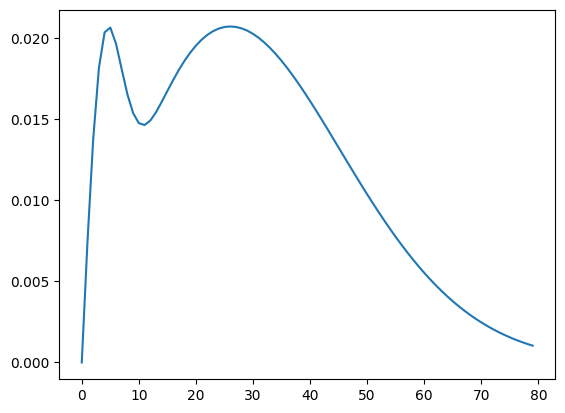

In [40]:
plt.plot(dxdfi)

In [41]:
ksi1, mt1, mv1, Fic1 = rez.x
Fi = np.linspace(0, Fiz, n_count)
sum(dx_exp - funcdxdf(Fi, ksi1, mt1, mv1, Fiz, Fic1))

np.float64(0.006236595905416782)

In [ ]:
0.053061807049350394
0.028374102094461007
-0.01374166981882453
0.006236595905416782